In [148]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
# from keras.losses import SparseCategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from keras import callbacks,layers

import time

In [149]:
def splits_assemble(path, test_size=0.3):
    # Import dataset
    df_dataset = pd.read_csv(path)

    # Encode Labels for numeric classification
    label_encoder = LabelEncoder()
    df_dataset['Label'] = label_encoder.fit_transform(df_dataset['Label'])

    # Set a random state for sampling
    RANDOM_STATE_SEED = np.random.randint(123)
    print(f'Random Seed:{RANDOM_STATE_SEED}')
    
    # Split dataset in train and test
    train, test = train_test_split(df_dataset, test_size=test_size, random_state=RANDOM_STATE_SEED)
    
    # Count how many instances there are in each label
    print(df_dataset["Label"].value_counts())

    # Separate in X and y for better classification
    y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
    X_train = train.values

    print(f'Tipo X_train: {type(X_train)} Tipo y_train: {type(y_train)} Shape X_train:{X_train.shape} Shape y_train: {y_train.shape}')

    y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
    X_test = test.values

    print(f'Tipo X_test: {type(X_test)} Tipo y_test: {type(y_test)} Shape X_test:{X_test.shape} Shape y_test: {y_test.shape}')
    
    return X_train,y_train,X_test,y_test

In [150]:
def models_assemble(X_train):
    models = {}

    models['DT'] = DecisionTreeClassifier()
    models['RF'] = RandomForestClassifier()
    models['SVM'] = LinearSVC(max_iter=10000, dual=False,)
    models['KNN'] = KNeighborsClassifier(algorithm='ball_tree')
    models['NB'] = GaussianNB()
    models['XGB'] = xgb.XGBClassifier()
    models['NN'] = keras.Sequential([
            layers.InputLayer(input_shape=(X_train.shape[1],)),
            
            layers.BatchNormalization(renorm=True),
            layers.Dense(128, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(64, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.Dense(1, activation='sigmoid'),
        ])
    return models

In [151]:
def grids_assemble(cv=2, model=None,key=None):
    
    hyperparameters = {}
    hyperparameters['XGB'] = {'learning_rate': [0.9, 0.7, 0.5, 0.3, 0.1], 'n_estimators': [50,100,150,200],
                              }
    hyperparameters['DT'] = {'criterion': ['gini','entropy'], 'max_depth': [10,15,20,25,30],'splitter':['best','random']
                             }
    hyperparameters['RF'] = {'n_estimators': [50, 75, 100, 125, 150], 'criterion': ['gini','entropy'],'max_depth': [25,30]
                             }
    hyperparameters['SVM'] = { 'C': np.linspace(0.01,100, num=20)
                              }
    hyperparameters['NB'] = {'var_smoothing': np.logspace(0,-9, num=20)
                             }
    hyperparameters['KNN'] = {'n_neighbors': [8,9,10,11,12], 'weights': ['uniform','distance'], 'leaf_size': [10,100]
                            }

    classifierGRID = GridSearchCV(
        estimator = model,
        param_grid = hyperparameters[key],
        cv=cv,
        verbose=1,
        n_jobs=-1  # Use all -4 available CPU cores
    )
    return classifierGRID

In [152]:
def fit_assemble(classifierGRID,X_train,y_train):
    classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_estimator_)
    print("---------------")
    


    fitted_model = classifierGRID.best_estimator_
    
    return fitted_model

In [153]:
def NeuralNet_fit(neuralNetModel,X_train,y_train,cv=2):
    # %%
    def neuralnet_create(epsilon):
        model=keras.Sequential([
                layers.InputLayer(input_shape=(X_train.shape[1],)),
                
                layers.BatchNormalization(renorm=True),
                layers.Dense(128, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(64, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(32, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.Dense(1, activation='sigmoid'),
            ])
        optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['binary_accuracy'],
        )
        return model
    # def neuralnet_create(epsilon):
    #     model=keras.Sequential([
    #             layers.InputLayer(input_shape=(X_train.shape[1],)),
                
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(128, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(64, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(32, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.Dense(2, activation='linear'),
    #         ])
    #     optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

    #     model.compile(
    #         optimizer=optimizer,
    #         loss= SparseCategoricalCrossentropy(from_logits=True),
    #         metrics=['binary_accuracy'],
    #     )
    #     return model
    # def lstm_autoencoder_create(epsilon):
    #     model=keras.Sequential([
    #             layers.LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],1)),
    #             layers.Dropout(rate = 0.3),
    #             layers.LSTM(units=50,return_sequences=True),
    #             layers.Dropout(rate = 0.3),
    #             layers.LSTM(units=50),
    #             layers.Dropout(rate = 0.3),
    #             layers.Dense(units=1),

    #         ])
    #     optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

    #     model.compile(
    #         optimizer=optimizer,
    #         loss='binary_crossentropy',
    #         metrics=['binary_accuracy'],
    #     )
    #     return model


    early_stopping = callbacks.EarlyStopping(
        min_delta = 0.001,
        patience = 7,
        restore_best_weights = True,
        monitor= 'loss'
    )

    hyperparameters = {'epochs': [50], 'batch_size': [128,256], 'callbacks':[early_stopping], 'epsilon':[0.001]
                            }



    neuralNetModel = KerasClassifier(build_fn=neuralnet_create)

    classifierGRID = GridSearchCV(
        estimator = neuralNetModel,
        param_grid = hyperparameters,
        cv=cv,
        verbose=1,
        n_jobs=-1,  # Use all -4 available CPU cores
        scoring='accuracy'
    )

    classifierGRID = classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_params_)
    print("---------------")
    
    fitted_model = classifierGRID.best_estimator_
    
    return fitted_model


In [154]:
def metrics_assemble(fitted_model,X_test,y_test):
    
    predictions = fitted_model.predict(X_test)

    if predictions.dtype == 'float32':
        predictions = (fitted_model.predict(X_test) > 0.5).astype("int32")

    
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions, average='weighted')
    recall = recall_score(y_test,predictions,average='weighted')
    f1= f1_score(y_test,predictions,average='weighted')
    auc= roc_auc_score(y_test,predictions,average='weighted')

    return accuracy, precision, recall, f1, auc

# Run ASSEMBLE

In [157]:
# Define path to the dataset
path = '/home/mintssj/Downloads/datasets/filtered/df_equal_DoS_GoldenEye.csv'

# Start dictionaries to store metrics
accuracy, precision, recall, f1, auc, fit_time, eval_time, fitted_models = {}, {}, {}, {}, {}, {}, {}, {} 

# Get dataset splits for tranning and evaluation
X_train,y_train,X_test,y_test = splits_assemble(path, test_size=0.3)

# Start dictionary for models
models=models_assemble(X_train)

# Start iteration loop for fitting and evaluating the classic models
for key in ['NB']:#'DT', 'RF', 'XGB', 'KNN', 'SVM', 'NB']:
    
    # Get the grid of hyperparameters and start the GridsearchCV function
    classifierGRID = grids_assemble(cv=2, model=models[key],key=key)

    print(f'Fitting {key} model')

    # Fit model
    start_time = time.time()
    fitted_models[key] = fit_assemble(classifierGRID,X_train,y_train)
    end_time = time.time()
    fit_time[key] = end_time - start_time

    # Evaluate model
    start_time = time.time()
    accuracy[key], precision[key], recall[key], f1[key], auc[key] = metrics_assemble(fitted_models[key],X_test,y_test)
    end_time = time.time()
    eval_time[key] = end_time - start_time

# Fit the neural network model
start_time = time.time()
fitted_models['NN'] = NeuralNet_fit(models['NN'],X_train,y_train, cv = 2)
end_time = time.time()
fit_time['NN'] = end_time - start_time

# Evaluate the neural network model
start_time = time.time()
accuracy['NN'], precision['NN'], recall['NN'], f1['NN'], auc['NN'] = metrics_assemble(fitted_models['NN'],X_test,y_test)
end_time = time.time()
eval_time['NN'] = end_time - start_time

# Convert the metrics dictionaries into a dataframe for better visualization
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score':f1, 'ROC-AUC-Score': auc, \
           'Tempo':fit_time, 'Evaluation Time':eval_time}
df_metrics = pd.DataFrame(metrics)
display(df_metrics)  


Random Seed:35
Label
0    39594
1    39594
Name: count, dtype: int64
Tipo X_train: <class 'numpy.ndarray'> Tipo y_train: <class 'numpy.ndarray'> Shape X_train:(55431, 52) Shape y_train: (55431,)
Tipo X_test: <class 'numpy.ndarray'> Tipo y_test: <class 'numpy.ndarray'> Shape X_test:(23757, 52) Shape y_test: (23757,)
Fitting NB model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

0.9979433754084202
---------------
Best performing hyperparameters on Validation set: 
GaussianNB(var_smoothing=2.6366508987303608e-08)
---------------
Fitting 2 folds for each of 2 candidates, totalling 4 fits


/tmp/ipykernel_98895/4116286988.py:82: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neuralNetModel = KerasClassifier(build_fn=neuralnet_create)
2023-06-01 13:08:11.861814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 13:08:11.893235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 13:08:11.893235: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-01 13:08:11.949948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
109/109 [==============================] - 3s 8ms/step - loss: 0.4194 - binary_accuracy: 0.8034
Epoch 2/50
109/109 [==============================] - 3s 8ms/step - loss: 0.4732 - binary_accuracy: 0.7536
Epoch 2/50
217/217 [==============================] - 3s 6ms/step - loss: 0.2484 - binary_accuracy: 0.8781
Epoch 2/50
217/217 [==============================] - 3s 6ms/step - loss: 0.2133 - binary_accuracy: 0.9115
Epoch 2/50
109/109 [==============================] - 1s 6ms/step - loss: 0.0173 - binary_accuracy: 0.9972
Epoch 3/50
109/109 [==============================] - 1s 6ms/step - loss: 0.0254 - binary_accuracy: 0.9948
Epoch 3/50
109/109 [==============================] - 1s 6ms/step - loss: 0.0070 - binary_accuracy: 0.9991
Epoch 4/50
217/217 [==============================] - 1s 5ms/step - loss: 0.0067 - binary_accuracy: 0.9992
Epoch 3/50
217/217 [==============================] - 1s 5ms/step - loss: 0.0057 - binary_accuracy: 0.9991
Epoc

KeyboardInterrupt: 

In [ ]:
df_metrics.to_csv('/home/mintssj/Downloads/CIC_DDoS_LOIC_HTTP_metrics.csv')

<Axes: >

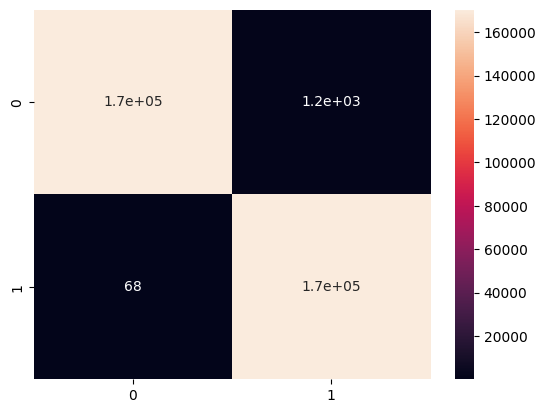

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = fitted_models['NB'].predict(X_test)
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True)  